   # Remote Monitoring of Power Data from a Manfacturing Site
   
   This project is to study data from a dashboard and alert system for a continuous monitoring system connected to the revenue meter of a manufacturing site.  The EMPATH Continuous Monitoring System (ECMS-1/https://empathcms.com) is a device that obtains three phases of voltage and current connected via TCP/IP to a client-server software for monitoring equipment condition.  It also has power quality aspects and an accuracy of greater than revenue grade 0.2 equivalent.  It uses a Microsoft Access database with three tables representing each phase with a GUI interface.  EMPATH systems are used as continuous monitoring electrical signature analysis devices and automatically troubleshoot electrical machinery including transformers and circuits using a combination of expert system and machine learning/AI.  The database used is a repository for the power quality data also collected in continuous monitoring.
   
   For evaluation and security, a copy of the database has been made and moved to a location other than the server used for real-time monitoring for this project.  https://github.com/MotorDoc1/energydata
   
   Copyright 2022 MotorDoc LLC and Howard W Penrose, Ph.D., CMRP
   
   Initial work - data science review.
   

# General discussion of what you are seeing in this work

The location of this facility is away from alternative energy and in the region that suffered as part of the Northeast blackout of August, 2003.  The local distribution grid is fed from a nearby coal-fired power plant which also supplies power to a bulk power grid.  The power issues are typical of what we find in rural traditional local power generation and distribution.

It is important to note that conditions such as those noted here generate nuisance tripping, electrical and electronic faults, and overloading of transformers and related conditions.

Reference Articles:

https://theramreview.com/part-i-more-thoughts-on-electrical-reliability/

https://theramreview.com/part-ii-more-thoughts-on-electrical-reliability/

https://theramreview.com/part-iii-more-thoughts-on-electrical-reliability-specifically-in-plant-surveys/

https://theramreview.com/part-1-electrical-grid-reliability-resilience-and-why-it-really-matters/

In [11]:
#these are the libraries that will be used to evaluate the data.  Additional libraries will be added in the notebook as needed.
import pyodbc
import re
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt 
import numpy as np
from statistics import mean

In [12]:
#Checks to see if you have the correct MS Access Driver.
[x for x in pyodbc.drivers() if x.startswith('Microsoft Access Driver')]

['Microsoft Access Driver (*.mdb, *.accdb)']

In [13]:
#connect to database
conn_str = (
    r'DRIVER={Microsoft Access Driver (*.mdb, *.accdb)};'
    r'DBQ=###insert local path here###;' #uses the trans.mdb data on a local drive.  A different method is used to connect
    #to the source directly online.
    )
cnxn = pyodbc.connect(conn_str)
crsr = cnxn.cursor()
for table_info in crsr.tables(tableType='TABLE'):
    print(table_info.table_name)

CalcInfoTable
RealtimeTable1
RealtimeTable2
RealtimeTable3


In [5]:
#import CalcInfoTable to review to determine what data required
query1 = "SELECT * FROM CalcInfoTable;"
calcIN = pd.read_sql(query1,cnxn)
print(calcIN.head())

  MotorType DrivenEq GearNumberRadio EfficiencyRating Enclosure PhaseRadio  \
0         3        0               0                1         0          1   

  AcquiredCPhasesRadio AnalyzeRadio AcquiredVPhasesRadio    Power  ...  \
0                    1            0                    0  10000.0  ...   

   DCController  LineFrequency  Woundmotor  Slipringmotor  AutofindRBSS  \
0             0              0           0              0             0   

   Reciprocatingequipment  AutofindSSZone SwitchCombo AddrCombo RadioGroup1  
0                       0               0           0        -1           1  

[1 rows x 27 columns]


In [6]:
#import per phase data to determine which data is required.  Note that some data is 'per phase' which means that other data
#from other columns will have to be added.
queryTB1 = "SELECT * FROM RealtimeTable1"
queryTB2 = "SELECT * FROM RealtimeTable2"
queryTB3 = "SELECT * FROM RealtimeTable3"
realTB1 = pd.read_sql(queryTB1,cnxn)
realTB2 = pd.read_sql(queryTB2,cnxn)
realTB3 = pd.read_sql(queryTB3,cnxn)
print(realTB1.head())
print(realTB2.head())
print(realTB3.head())

         DownloadTime TestType  MtrCurrent  Voltage  Powerfactor   Power  \
0 2022-05-07 16:34:54  Default       118.1  11794.0        0.880   704.9   
1 2022-08-02 06:41:52  Default       166.0  12946.0        0.851  1094.2   
2 2022-08-02 06:56:56  Default       167.6  12941.0        0.854  1109.9   
3 2022-08-02 07:11:56  Default       168.4  12879.0        0.845  1097.5   
4 2022-08-02 07:26:54  Default       175.2  12932.0        0.852  1160.1   

     THDC   THDV  Load  Efficiency  ...  MechUnbRatio  SlipSBdB  RBHI  \
0   8.987  1.030  28.7         0.0  ...           0.0       0.0   0.0   
1  10.197  2.358  41.8         0.0  ...           0.0       0.0   0.0   
2  10.442  2.571  42.4         0.0  ...           0.0       0.0   0.0   
3  10.227  1.644  42.3         0.0  ...           0.0       0.0   0.0   
4  11.249  1.555  43.2         0.0  ...           0.0       0.0   0.0   

   PFVariation  LineFreq     RPM  PPF  RBHealthIndex  VFratio  \
0         10.6    59.958  59.958  0.0  

In [7]:
#eliminate unneeded columns in each table.
realTB1.drop(['TestType','Efficiency','MechUnbRatio','SlipSBdB','RBHI','RPM','PPF',
              'OutputTorque','RBHealthIndex','VFratio','StatEccentricity'],
            axis=1, inplace=True)
realTB2.drop(['TestType','Load','Efficiency','MechUnbRatio','SlipSBdB','RBHI', 'PFVariation', 'LineFreq','RPM','PPF',
              'OutputTorque','RBHealthIndex','VFratio','StatEccentricity'],axis=1, inplace=True)
realTB3.drop(['TestType','Load','Efficiency','MechUnbRatio','SlipSBdB','RBHI', 'PFVariation', 'LineFreq','RPM','PPF',
              'OutputTorque','RBHealthIndex','VFratio','StatEccentricity'],axis=1, inplace=True)
print(realTB1.head())
print(realTB2.head())
print(realTB3.head())

         DownloadTime  MtrCurrent  Voltage  Powerfactor   Power    THDC  \
0 2022-05-07 16:34:54       118.1  11794.0        0.880   704.9   8.987   
1 2022-08-02 06:41:52       166.0  12946.0        0.851  1094.2  10.197   
2 2022-08-02 06:56:56       167.6  12941.0        0.854  1109.9  10.442   
3 2022-08-02 07:11:56       168.4  12879.0        0.845  1097.5  10.227   
4 2022-08-02 07:26:54       175.2  12932.0        0.852  1160.1  11.249   

    THDV  Load  PFVariation  LineFreq  
0  1.030  28.7         10.6    59.958  
1  2.358  41.8          7.2    59.932  
2  2.571  42.4          6.7    59.958  
3  1.644  42.3          6.6    59.932  
4  1.555  43.2          7.1    59.932  
         DownloadTime  MtrCurrent  Voltage  Powerfactor  Power   THDC   THDV
0 2022-05-07 16:34:54       114.3  11763.0        0.893  689.9  8.517  1.056
1 2022-08-02 06:41:52       158.7  12180.0        0.871  975.9  9.650  2.349
2 2022-08-02 06:56:56       160.1  12178.0        0.877  990.8  9.713  2.571
3

In [8]:
realTB1.describe()

,MtrCurrent,Voltage,Powerfactor,Power,THDC,THDV,Load,PFVariation,LineFreq
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000
mean,155.265430,12232.081400,0.857567,948.796170,9.566436,1.331052,37.28350,6.002150,59.929274
std,25.372477,553.667592,0.014626,148.996093,1.721159,0.292493,5.74494,2.493376,0.022681
min,46.300000,11611.000000,0.812000,265.500000,1.132000,0.319000,11.20000,1.000000,59.857000
25%,137.200000,11779.000000,0.848000,841.100000,8.500750,1.143000,33.20000,3.700000,59.906000
50%,156.400000,11906.000000,0.857000,955.300000,9.565000,1.288000,37.60000,6.400000,59.932000
75%,174.800000,12693.000000,0.867000,1058.625000,10.752250,1.478000,41.90000,7.800000,59.932000
max,233.600000,13742.000000,0.911000,1416.400000,21.729000,3.106000,53.30000,16.200000,60.109000


In [9]:
realTB2.describe()

,MtrCurrent,Voltage,Powerfactor,Power,THDC,THDV
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,146.973120,11938.997800,0.869346,876.672630,8.942696,1.407535
std,24.462735,203.189418,0.014810,137.847657,1.452384,0.303955
min,44.100000,11603.000000,0.821000,265.200000,1.021000,0.324000
25%,129.500000,11771.000000,0.859000,779.100000,8.094750,1.200000
50%,148.300000,11857.000000,0.868000,883.300000,8.975000,1.383000
75%,165.700000,12114.000000,0.879000,988.000000,9.854250,1.582000
max,216.000000,12501.000000,0.925000,1237.600000,22.094000,3.029000


In [10]:
realTB3.describe()

,MtrCurrent,Voltage,Powerfactor,Power,THDC,THDV
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,154.829170,12350.946800,0.876870,955.909580,9.828204,1.316427
std,25.743147,754.907411,0.016607,146.959076,1.706634,0.272322
min,49.700000,11545.000000,0.811000,301.400000,1.343000,0.160000
25%,136.500000,11731.000000,0.866000,852.475000,8.754000,1.156000
50%,155.800000,11904.000000,0.878000,963.050000,9.906000,1.294000
75%,174.600000,12986.000000,0.889000,1074.450000,11.044000,1.445000
max,236.900000,14486.000000,0.923000,1406.000000,24.045000,2.934000


In [11]:
#rename columns to represent all three phases
realTB1 = realTB1.rename(columns = {'DownloadTime':'Time','MtrCurrent':'Amp1', 'Voltage':'Volt1', 'Powerfactor':'PF1','Power':'Watt1',
                          'THDC':'THDC1', 'THDV':'THDV1'})
realTB2 = realTB2.rename(columns = {'MtrCurrent':'Amp2', 'Voltage':'Volt2', 'Powerfactor':'PF2','Power':'Watt2',
                          'THDC':'THDC2', 'THDV':'THDV2'})
realTB3 = realTB3.rename(columns = {'MtrCurrent':'Amp3', 'Voltage':'Volt3', 'Powerfactor':'PF3','Power':'Watt3',
                          'THDC':'THDC3', 'THDV':'THDV3'})


In [12]:
#concat tables and dropna, drop additional time columns
realTB4 = pd.concat([realTB1, realTB2, realTB3], axis = 1, join = 'inner')
realTB4 = realTB4.dropna()
realTB4 = realTB4.sort_values(by = 'Time')
realTB4 = realTB4.reset_index(drop=True)
realTB4.head()

,Time,Amp1,Volt1,PF1,Watt1,THDC1,THDV1,Load,PFVariation,LineFreq,...,Watt2,THDC2,THDV2,DownloadTime,Amp3,Volt3,PF3,Watt3,THDC3,THDV3
0,2022-04-29 11:13:52,168.4,11807.0,0.848,967.3,1.620,0.415,39.2,6.9,60.086,...,916.2,1.489,0.459,2022-04-29 11:13:52,169.8,11733.0,0.894,1041.3,1.679,0.258
1,2022-04-29 11:28:52,165.4,11815.0,0.850,953.4,1.865,0.428,38.6,6.7,60.086,...,904.1,1.472,0.466,2022-04-29 11:28:52,166.6,11743.0,0.894,1021.7,1.801,0.271
2,2022-04-29 11:43:56,161.4,11820.0,0.854,935.2,2.219,0.508,38.0,6.6,60.063,...,893.0,2.136,0.495,2022-04-29 11:43:56,163.3,11745.0,0.898,1005.8,2.229,0.290
3,2022-04-29 11:58:56,171.3,11825.0,0.841,977.2,1.393,0.445,40.3,5.7,60.063,...,958.8,2.006,0.422,2022-04-29 11:58:56,176.0,11727.0,0.886,1067.3,1.478,0.250
4,2022-04-29 12:13:56,157.9,11835.0,0.852,912.8,1.607,0.443,37.7,6.7,60.063,...,895.4,1.939,0.449,2022-04-29 12:13:56,163.8,11729.0,0.897,1005.6,1.752,0.280


In [13]:
#realTB4.drop(realTB4.columns[[-7, -14]], axis = 1, inplace = True)
#realTB4.head()

In [14]:
realTB4.describe()

,Amp1,Volt1,PF1,Watt1,THDC1,THDV1,Load,PFVariation,LineFreq,Amp2,...,PF2,Watt2,THDC2,THDV2,Amp3,Volt3,PF3,Watt3,THDC3,THDV3
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,...,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,155.265430,12232.081400,0.857567,948.796170,9.566436,1.331052,37.28350,6.002150,59.929274,146.973120,...,0.869346,876.672630,8.942696,1.407535,154.829170,12350.946800,0.876870,955.909580,9.828204,1.316427
std,25.372477,553.667592,0.014626,148.996093,1.721159,0.292493,5.74494,2.493376,0.022681,24.462735,...,0.014810,137.847657,1.452384,0.303955,25.743147,754.907411,0.016607,146.959076,1.706634,0.272322
min,46.300000,11611.000000,0.812000,265.500000,1.132000,0.319000,11.20000,1.000000,59.857000,44.100000,...,0.821000,265.200000,1.021000,0.324000,49.700000,11545.000000,0.811000,301.400000,1.343000,0.160000
25%,137.200000,11779.000000,0.848000,841.100000,8.500750,1.143000,33.20000,3.700000,59.906000,129.500000,...,0.859000,779.100000,8.094750,1.200000,136.500000,11731.000000,0.866000,852.475000,8.754000,1.156000
50%,156.400000,11906.000000,0.857000,955.300000,9.565000,1.288000,37.60000,6.400000,59.932000,148.300000,...,0.868000,883.300000,8.975000,1.383000,155.800000,11904.000000,0.878000,963.050000,9.906000,1.294000
75%,174.800000,12693.000000,0.867000,1058.625000,10.752250,1.478000,41.90000,7.800000,59.932000,165.700000,...,0.879000,988.000000,9.854250,1.582000,174.600000,12986.000000,0.889000,1074.450000,11.044000,1.445000
max,233.600000,13742.000000,0.911000,1416.400000,21.729000,3.106000,53.30000,16.200000,60.109000,216.000000,...,0.925000,1237.600000,22.094000,3.029000,236.900000,14486.000000,0.923000,1406.000000,24.045000,2.934000


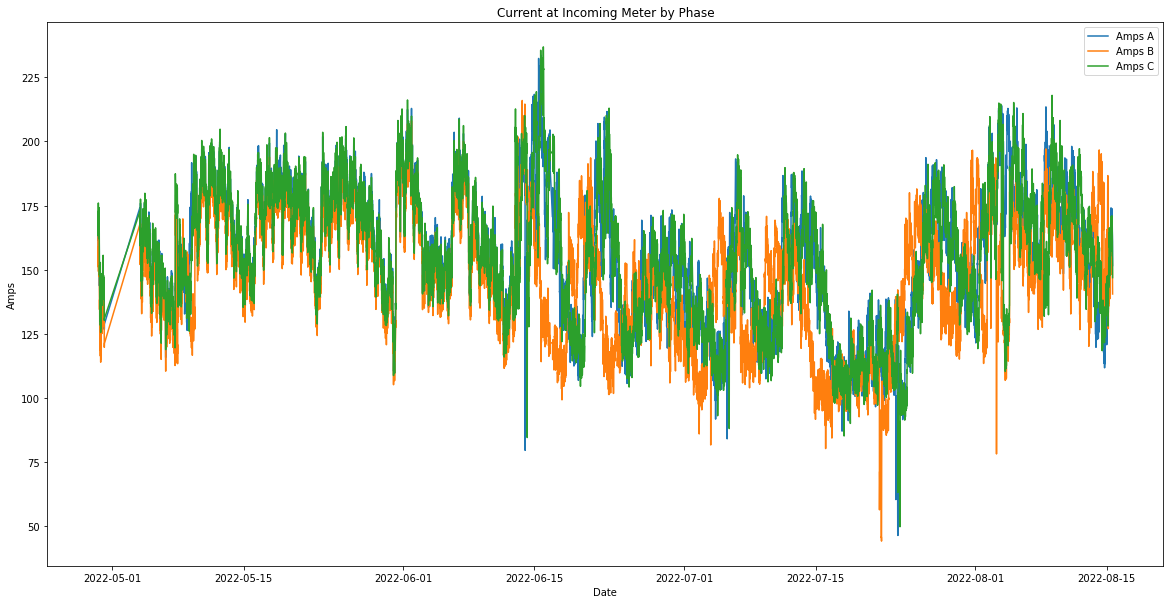

In [15]:
#Review current values
#fig, ax = plt.subplots()
y1=realTB4.Amp1
y2=realTB4.Amp2
y3=realTB4.Amp3
plt.figure(figsize=(20, 10))
plt.plot(realTB4.Time,y1,label = "Amps A")
plt.plot(realTB4.Time,y2,label = "Amps B")
plt.plot(realTB4.Time,y3,label = "Amps C")
plt.title('Current at Incoming Meter by Phase')
plt.xlabel('Date')
plt.ylabel('Amps')
plt.legend()

plt.show()

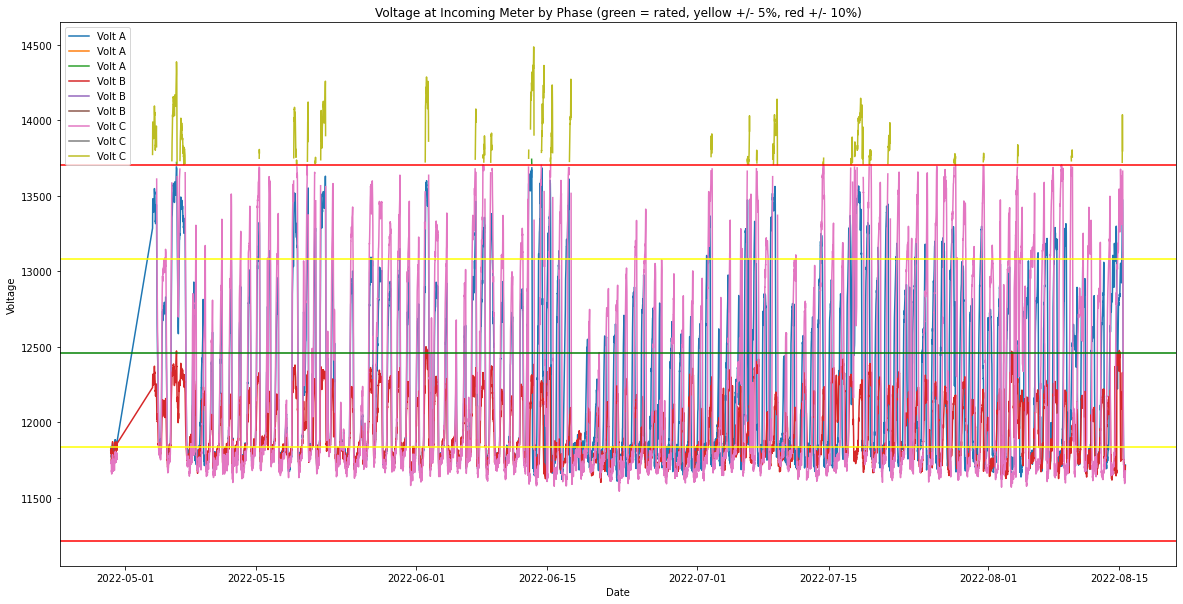

In [16]:
#review upper and lower limits for Voltage
s1 = realTB4.Volt1
s2 = realTB4.Volt2
s3 = realTB4.Volt3
t = realTB4.Time

upper = (12460*1.1)
lower = (12460*0.9)
midU = (12460*1.05)
midL = (12460*0.95)
rated = 12460

supper1 = np.ma.masked_where(s1 < upper, s1)
slower1 = np.ma.masked_where(s1 > lower, s1)
smiddle1 = np.ma.masked_where((s1 < lower)| (s1 > upper), s1)

supper2 = np.ma.masked_where(s2 < upper, s2)
slower2 = np.ma.masked_where(s2 > lower, s2)
smiddle2 = np.ma.masked_where((s2 < lower)| (s2 > upper), s2)

supper3 = np.ma.masked_where(s3 < upper, s3)
slower3 = np.ma.masked_where(s3 > lower, s3)
smiddle3 = np.ma.masked_where((s3 < lower)| (s3 > upper), s3)

plt.figure(figsize = (20, 10))
plt.plot(t, smiddle1, t, slower1, t, supper1, label = "Volt A")
plt.plot(t, smiddle2, t, slower2, t, supper2, label = "Volt B")
plt.plot(t, smiddle3, t, slower3, t, supper3, label = "Volt C")
plt.axhline(y=np.nanmean(upper), color = 'red')
plt.axhline(y=np.nanmean(lower), color = 'red')
plt.axhline(y=np.nanmean(midU), color = 'yellow')
plt.axhline(y=np.nanmean(midL), color = 'yellow')
plt.axhline(y=np.nanmean(rated), color = 'green')
plt.title('Voltage at Incoming Meter by Phase (green = rated, yellow +/- 5%, red +/- 10%)')
plt.xlabel('Date')
plt.ylabel('Voltage')
plt.legend()
plt.show()

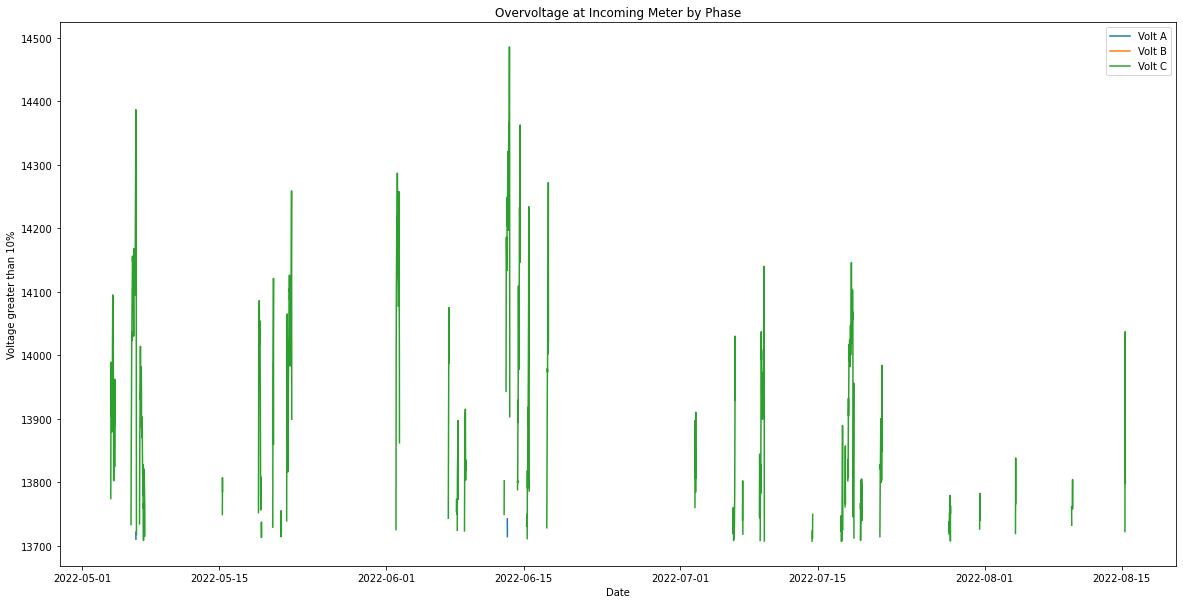

In [17]:
#plot just the overvoltages
plt.figure(figsize = (20, 10))
plt.plot(t,supper1, label = "Volt A")
plt.plot(t,supper2, label = "Volt B")
plt.plot(t,supper3, label = "Volt C")
plt.title('Overvoltage at Incoming Meter by Phase')
plt.xlabel('Date')
plt.ylabel('Voltage greater than 10%')
plt.legend()
plt.show()

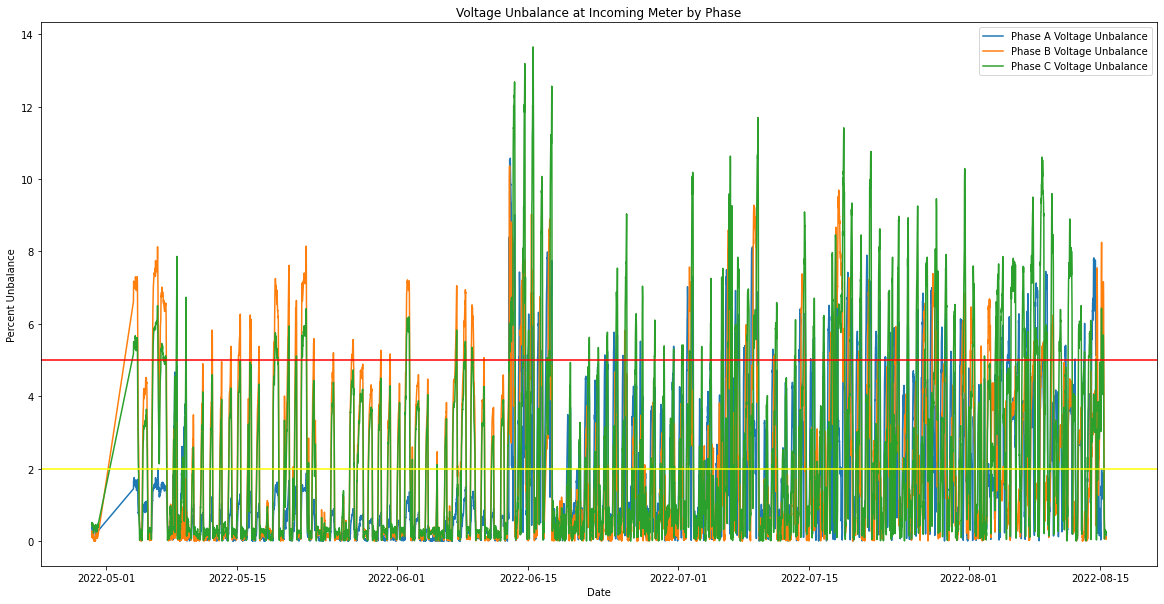

In [18]:
#Voltage Unbalance
unUpper = 5
unLower = 2

plt.figure(figsize = (20,10))

plt.plot(t,(abs(1-(s1/((s1+s2+s3)/3)))*100), label = "Phase A Voltage Unbalance")
plt.plot(t,(abs(1-(s2/((s1+s2+s3)/3)))*100), label = "Phase B Voltage Unbalance")
plt.plot(t,(abs(1-(s3/((s1+s2+s3)/3)))*100), label = "Phase C Voltage Unbalance")
plt.axhline(y=np.nanmean(unUpper), color = 'red')
plt.axhline(y=np.nanmean(unLower), color = 'yellow')
plt.title('Voltage Unbalance at Incoming Meter by Phase')
plt.xlabel('Date')
plt.ylabel('Percent Unbalance')
plt.legend()
plt.show()

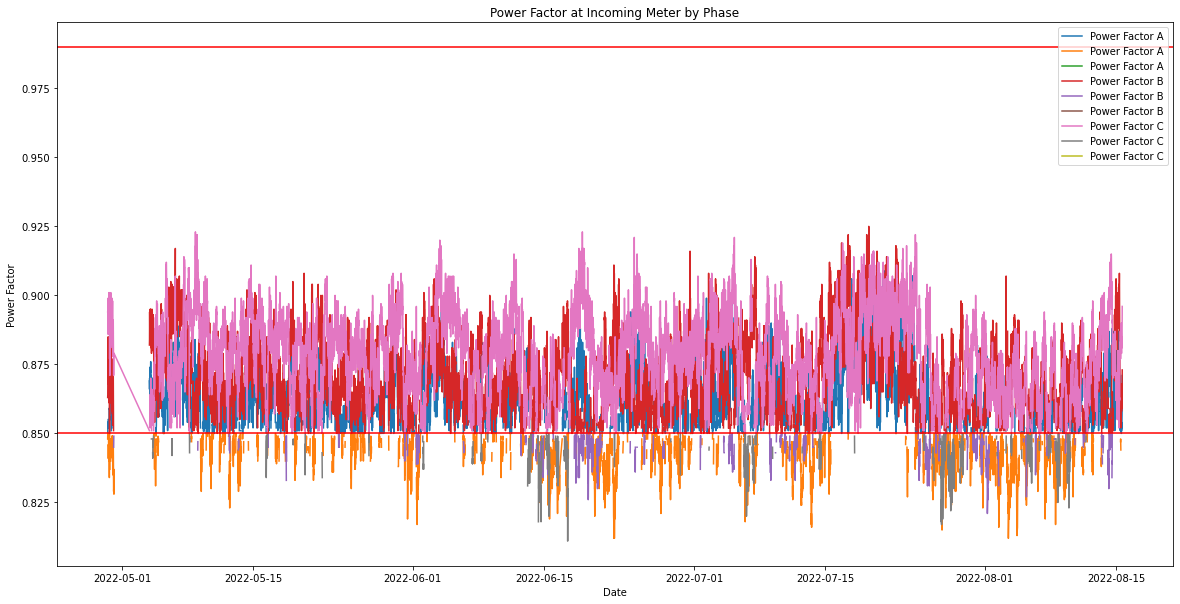

In [19]:
#review upper and lower limits for Power Factor
ps1 = realTB4.PF1
ps2 = realTB4.PF2
ps3 = realTB4.PF3
t = realTB4.Time

pupper = 0.99
plower = 0.85

psupper1 = np.ma.masked_where(ps1 < pupper, ps1)
pslower1 = np.ma.masked_where(ps1 > plower, ps1)
psmiddle1 = np.ma.masked_where((ps1 < plower)| (ps1 > pupper), ps1)

psupper2 = np.ma.masked_where(ps2 < pupper, ps2)
pslower2 = np.ma.masked_where(ps2 > plower, ps2)
psmiddle2 = np.ma.masked_where((ps2 < plower)| (ps2 > pupper), ps2)

psupper3 = np.ma.masked_where(ps3 < pupper, ps3)
pslower3 = np.ma.masked_where(ps3 > plower, ps3)
psmiddle3 = np.ma.masked_where((ps3 < plower)| (ps3 > pupper), ps3)

plt.figure(figsize = (20, 10))
plt.plot(t, psmiddle1, t, pslower1, t, psupper1, label = "Power Factor A")
plt.plot(t, psmiddle2, t, pslower2, t, psupper2, label = "Power Factor B")
plt.plot(t, psmiddle3, t, pslower3, t, psupper3, label = "Power Factor C")
plt.axhline(y=np.nanmean(pupper), color = 'red')
plt.axhline(y=np.nanmean(plower), color = 'red')
plt.title('Power Factor at Incoming Meter by Phase')
plt.xlabel('Date')
plt.ylabel('Power Factor')
plt.legend()
plt.show()

In [20]:
# Percentage of time over and under Voltage and Power Factor
ctIN = realTB4.Time.count()
vtOV = supper3.count()+supper2.count()+supper3.count()
vtPER = vtOV/ctIN
pfUN = pslower1.count()+pslower2.count()+pslower3.count()
pfPER = pfUN/ctIN
print("Overvoltage = ", vtPER), print("Low PF = ", pfPER)

Overvoltage =  0.1382
Low PF =  0.4833


(None, None)

No handles with labels found to put in legend.


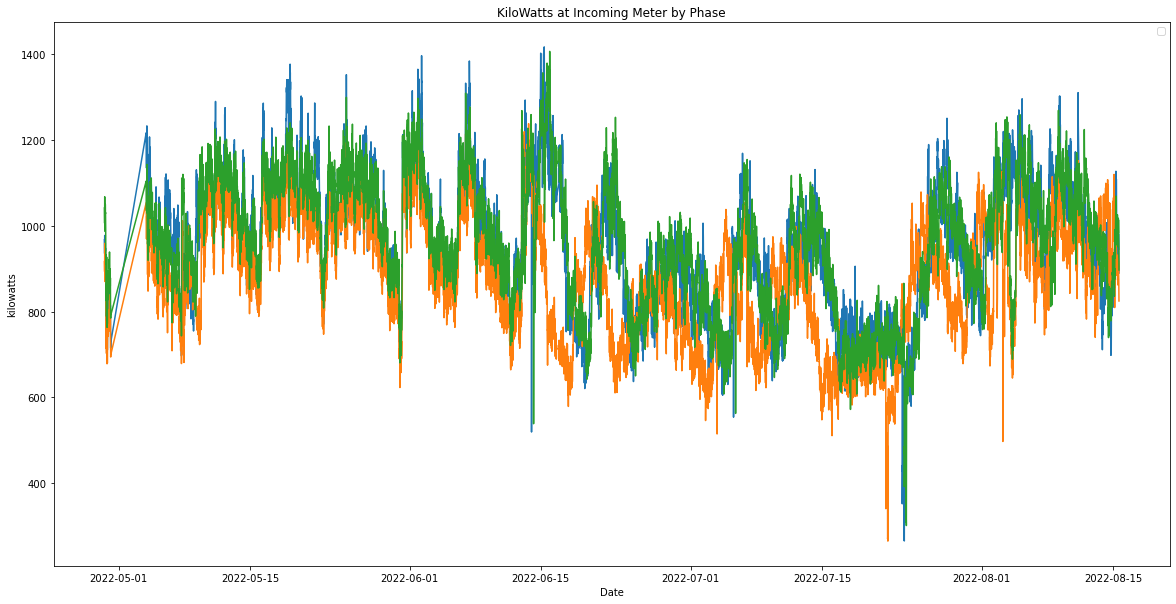

In [21]:
#Watts by phase
plt.figure(figsize = (20, 10))
plt.plot(t, realTB4.Watt1)
plt.plot(t, realTB4.Watt2)
plt.plot(t, realTB4.Watt3)
plt.title('KiloWatts at Incoming Meter by Phase')
plt.xlabel('Date')
plt.ylabel('kilowatts')
plt.legend()
plt.show()

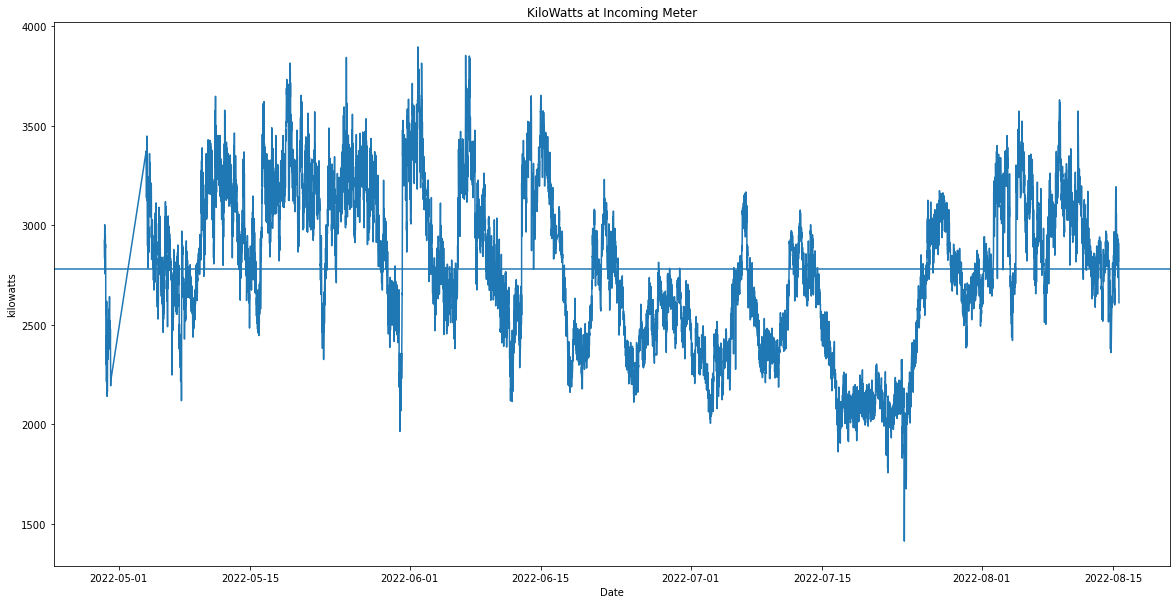

2781.37838 Average kW


In [22]:
# Watts Total
wattTOTAL = realTB4.Watt1 + realTB4.Watt2 + realTB4.Watt3
wattAVG = mean(wattTOTAL)
plt.figure(figsize = (20,10))
plt.plot(t, wattTOTAL)
plt.axhline(y=np.nanmean(wattAVG))
plt.title('KiloWatts at Incoming Meter')
plt.xlabel('Date')
plt.ylabel('kilowatts')
plt.show()

print(wattAVG, "Average kW")

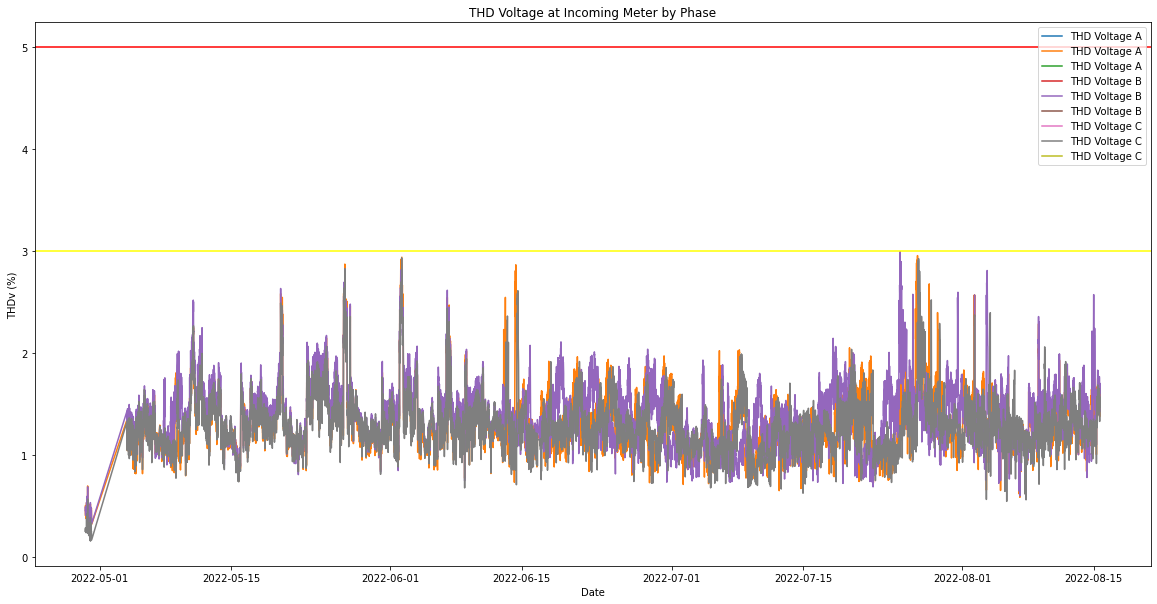

In [27]:
# Harmonic Content THDv

thdv1 = realTB4.THDV1
thdv2 = realTB4.THDV2
thdv3 = realTB4.THDV3
t = realTB4.Time

pupper = 5
plower = 3

psupper1 = np.ma.masked_where(thdv1 < pupper, thdv1)
pslower1 = np.ma.masked_where(thdv1 > plower, thdv1)
psmiddle1 = np.ma.masked_where((thdv1 < plower)| (thdv1 > pupper), thdv1)

psupper2 = np.ma.masked_where(thdv2 < pupper, thdv2)
pslower2 = np.ma.masked_where(thdv2 > plower, thdv2)
psmiddle2 = np.ma.masked_where((thdv2 < plower)| (thdv2 > pupper), thdv2)

psupper3 = np.ma.masked_where(thdv3 < pupper, thdv3)
pslower3 = np.ma.masked_where(thdv3 > plower, thdv3)
psmiddle3 = np.ma.masked_where((thdv3 < plower)| (thdv3 > pupper), thdv3)

plt.figure(figsize = (20, 10))
plt.plot(t, psmiddle1, t, pslower1, t, psupper1, label = "THD Voltage A")
plt.plot(t, psmiddle2, t, pslower2, t, psupper2, label = "THD Voltage B")
plt.plot(t, psmiddle3, t, pslower3, t, psupper3, label = "THD Voltage C")
plt.axhline(y=np.nanmean(pupper), color = 'red')
plt.axhline(y=np.nanmean(plower), color = 'yellow')
plt.title('THD Voltage at Incoming Meter by Phase')
plt.xlabel('Date')
plt.ylabel('THDv (%)')
plt.legend()
plt.show()

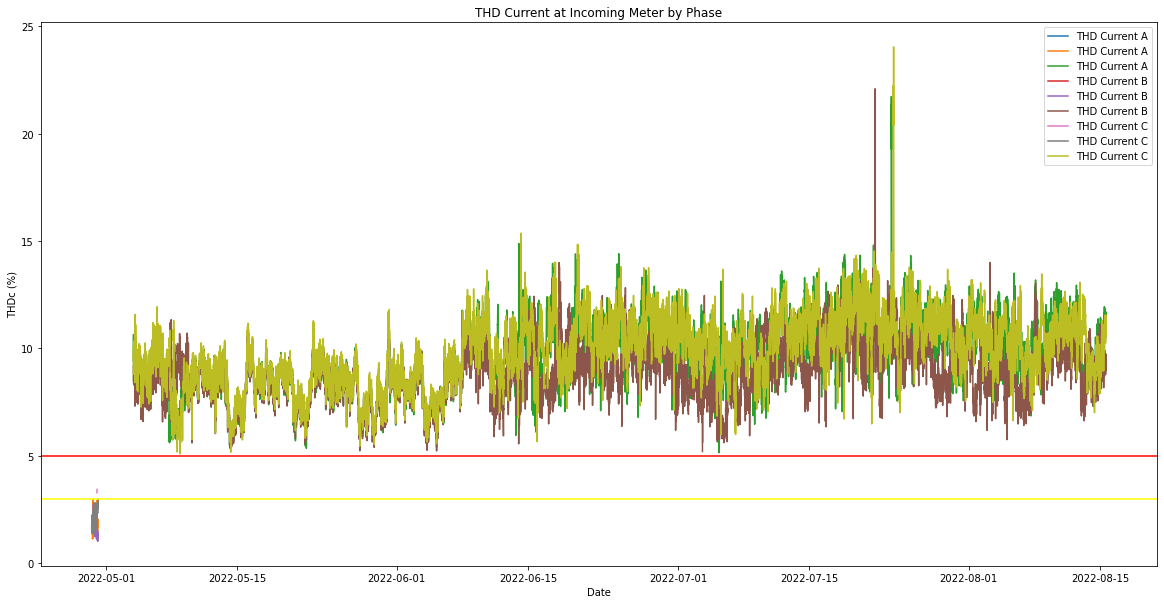

In [29]:
# Harmonic Content THDc

thdv1 = realTB4.THDC1
thdv2 = realTB4.THDC2
thdv3 = realTB4.THDC3
t = realTB4.Time

pupper = 5
plower = 3

psupper1 = np.ma.masked_where(thdv1 < pupper, thdv1)
pslower1 = np.ma.masked_where(thdv1 > plower, thdv1)
psmiddle1 = np.ma.masked_where((thdv1 < plower)| (thdv1 > pupper), thdv1)

psupper2 = np.ma.masked_where(thdv2 < pupper, thdv2)
pslower2 = np.ma.masked_where(thdv2 > plower, thdv2)
psmiddle2 = np.ma.masked_where((thdv2 < plower)| (thdv2 > pupper), thdv2)

psupper3 = np.ma.masked_where(thdv3 < pupper, thdv3)
pslower3 = np.ma.masked_where(thdv3 > plower, thdv3)
psmiddle3 = np.ma.masked_where((thdv3 < plower)| (thdv3 > pupper), thdv3)

plt.figure(figsize = (20, 10))
plt.plot(t, psmiddle1, t, pslower1, t, psupper1, label = "THD Current A")
plt.plot(t, psmiddle2, t, pslower2, t, psupper2, label = "THD Current B")
plt.plot(t, psmiddle3, t, pslower3, t, psupper3, label = "THD Current C")
plt.axhline(y=np.nanmean(pupper), color = 'red')
plt.axhline(y=np.nanmean(plower), color = 'yellow')
plt.title('THD Current at Incoming Meter by Phase')
plt.xlabel('Date')
plt.ylabel('THDc (%)')
plt.legend()
plt.show()